In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import to_rgba
import warnings

# --- Basic Setup ---
warnings.filterwarnings("ignore")
# plt.style.use('seaborn-v0_8-whitegrid') # Style removed to eliminate grid

# Check for available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- 1. Define Data Distributions ---
# Distributions are moved further apart to be near the plot edges.
# Initial distribution p₀ (a single Gaussian)
p0_mean = torch.tensor([-5.0, 0.0], device=device) # Moved to the left
p0_cov = torch.tensor([[0.8, 0.5], [0.5, 1.5]], device=device)

# Target distribution p₁ (a mixture of two Gaussians)
p1_means = [
    torch.tensor([5.0, 3.0], device=device),  # Moved to the right
    torch.tensor([5.0, -3.0], device=device) # Moved to the right
]
p1_covs = [
    torch.tensor([[0.5, -0.3], [-0.3, 0.5]], device=device),
    torch.tensor([[0.5, 0.3], [0.3, 0.5]], device=device)
]
p1_weights = torch.tensor([0.5, 0.5], device=device)


def sample_p0(n_samples):
    """Sample from the initial distribution p₀."""
    dist = torch.distributions.MultivariateNormal(p0_mean, p0_cov)
    return dist.sample((n_samples,))

def sample_p1(n_samples):
    """Sample from the target mixture distribution p₁."""
    indices = torch.multinomial(p1_weights, n_samples, replacement=True)
    samples = torch.zeros(n_samples, 2, device=device)
    for i, (mean, cov) in enumerate(zip(p1_means, p1_covs)):
        mask = indices == i
        n_choice = mask.sum()
        if n_choice > 0:
            dist = torch.distributions.MultivariateNormal(mean, cov)
            samples[mask] = dist.sample((n_choice,))
    return samples

# --- 2. Define the Neural Network Model ---

class VectorFieldNet(nn.Module):
    """A simple MLP to approximate the vector field v(x, t)."""
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x, t):
        t_reshaped = t.view(-1, 1)
        xt = torch.cat([x, t_reshaped], dim=1)
        return self.net(xt)


# --- 3. Train the Model ---

def train_flow_matching(model, epochs=5000, batch_size=2048, lr=1e-3):
    """Train the Flow Matching model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    print("Starting training...")

    for epoch in range(epochs):
        optimizer.zero_grad()

        x0 = sample_p0(batch_size)
        x1 = sample_p1(batch_size)
        t = torch.rand(batch_size, device=device)

        x_t = (1 - t.unsqueeze(1)) * x0 + t.unsqueeze(1) * x1
        u_t = x1 - x0

        v_pred = model(x_t, t)

        loss = loss_fn(v_pred, u_t)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    print("Training finished!")

# --- 4. ODE Solver (Heun's Method) ---

def solve_ode_heun(model, x0, num_steps):
    """Solve the ODE dx/dt = v(x,t) using Heun's method."""
    model.eval()
    trajectory = [x0.clone()]
    x = x0.clone()
    dt = 1.0 / num_steps

    with torch.no_grad():
        for i in range(num_steps):
            t = torch.full((x.size(0),), i * dt, device=device)
            v_pred = model(x, t)
            x_tilde = x + dt * v_pred
            t_next = torch.full((x.size(0),), (i + 1) * dt, device=device)
            v_tilde = model(x_tilde, t_next)
            x = x + 0.5 * dt * (v_pred + v_tilde)
            trajectory.append(x.clone())

    return torch.stack(trajectory).cpu().numpy()

# --- 5. Visualization Functions ---

def create_subplot(ax, trajectories, x0_samples, x1_samples, num_steps):
    """Draws a single subplot with enhanced visual clarity."""
    color_p0 = '#5681EB'
    color_p1 = '#DD6772'

    # Set background to white and remove grid
    ax.set_facecolor('white')
    ax.grid(False)
    ax.axis('off')

    # Plot target and initial distributions with larger markers
    ax.scatter(x1_samples[:, 0], x1_samples[:, 1],
               color=color_p1, alpha=0.3, s=60, label='Target Dist. ($\mathbf{p_1}$)')
    ax.scatter(x0_samples[:, 0], x0_samples[:, 1],
               color=color_p0, alpha=0.8, s=60, label='Initial Dist. ($\mathbf{p_0}$)')

    # Prepare for drawing trajectories
    lines = []
    colors = []

    start_rgba = np.array(to_rgba(color_p0))
    end_rgba = np.array(to_rgba(color_p1))

    for i in range(trajectories.shape[1]):
        points = trajectories[:, i, :]
        segments = np.array([points[:-1], points[1:]]).transpose(1, 0, 2)
        lines.extend(segments)

        t_fractions = np.linspace(0, 1, num_steps)
        segment_colors = (1 - t_fractions[:, np.newaxis]) * start_rgba + t_fractions[:, np.newaxis] * end_rgba
        colors.extend(segment_colors)

    # Use thicker lines for trajectories
    lc = LineCollection(lines, colors=colors, linewidths=1.5, alpha=0.7)
    ax.add_collection(lc)

    # Set titles and labels with larger, bold font
    if num_steps == 1:
        ax.set_title('1 Step', fontsize=32, fontweight='bold')
    else:
        ax.set_title(f'{num_steps} Steps', fontsize=32, fontweight='bold')

    # Set legend with bold font and larger size
    ax.legend(
        loc='upper left',
        prop={'weight': 'bold', 'size': 26},
        labelcolor=[color_p1, color_p0],
        markerscale=1.5,
        frameon=False
    )

    ax.axis('equal')
    # Adjust limits to frame the spread-out distributions
    ax.set_xlim(-8, 8)
    ax.set_ylim(-7, 7)

def visualize_trajectories(model, n_samples=300):
    """Creates a single figure with three subplots and enhanced visuals."""
    steps_to_plot = [1, 3, 5]
    fig, axes = plt.subplots(1, 3, figsize=(28, 9))
    fig.patch.set_facecolor('white') # Set figure background to white

    # Set a main title with large, bold font
    fig.suptitle('Flow Matching Trajectories', fontsize=26, fontweight='bold')

    x0_samples = sample_p0(n_samples).cpu().numpy()
    x1_samples = sample_p1(n_samples * 2).cpu().numpy()
    x0_tensor = torch.tensor(x0_samples, device=device)

    for ax, num_steps in zip(axes, steps_to_plot):
        trajectories = solve_ode_heun(model, x0_tensor, num_steps)
        create_subplot(ax, trajectories, x0_samples, x1_samples, num_steps)

    plt.tight_layout(rect=[0, 0.03, 1, 0.93]) # Adjust layout for main title
    plt.show()



Using device: cuda


Starting training...
Epoch [500/5000], Loss: 3.050148
Epoch [1000/5000], Loss: 2.996001
Epoch [1500/5000], Loss: 2.919065
Epoch [2000/5000], Loss: 2.848191
Epoch [2500/5000], Loss: 2.820388
Epoch [3000/5000], Loss: 2.736392
Epoch [3500/5000], Loss: 2.661519
Epoch [4000/5000], Loss: 2.759752
Epoch [4500/5000], Loss: 2.830106


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Epoch [5000/5000], Loss: 2.848886
Training finished!


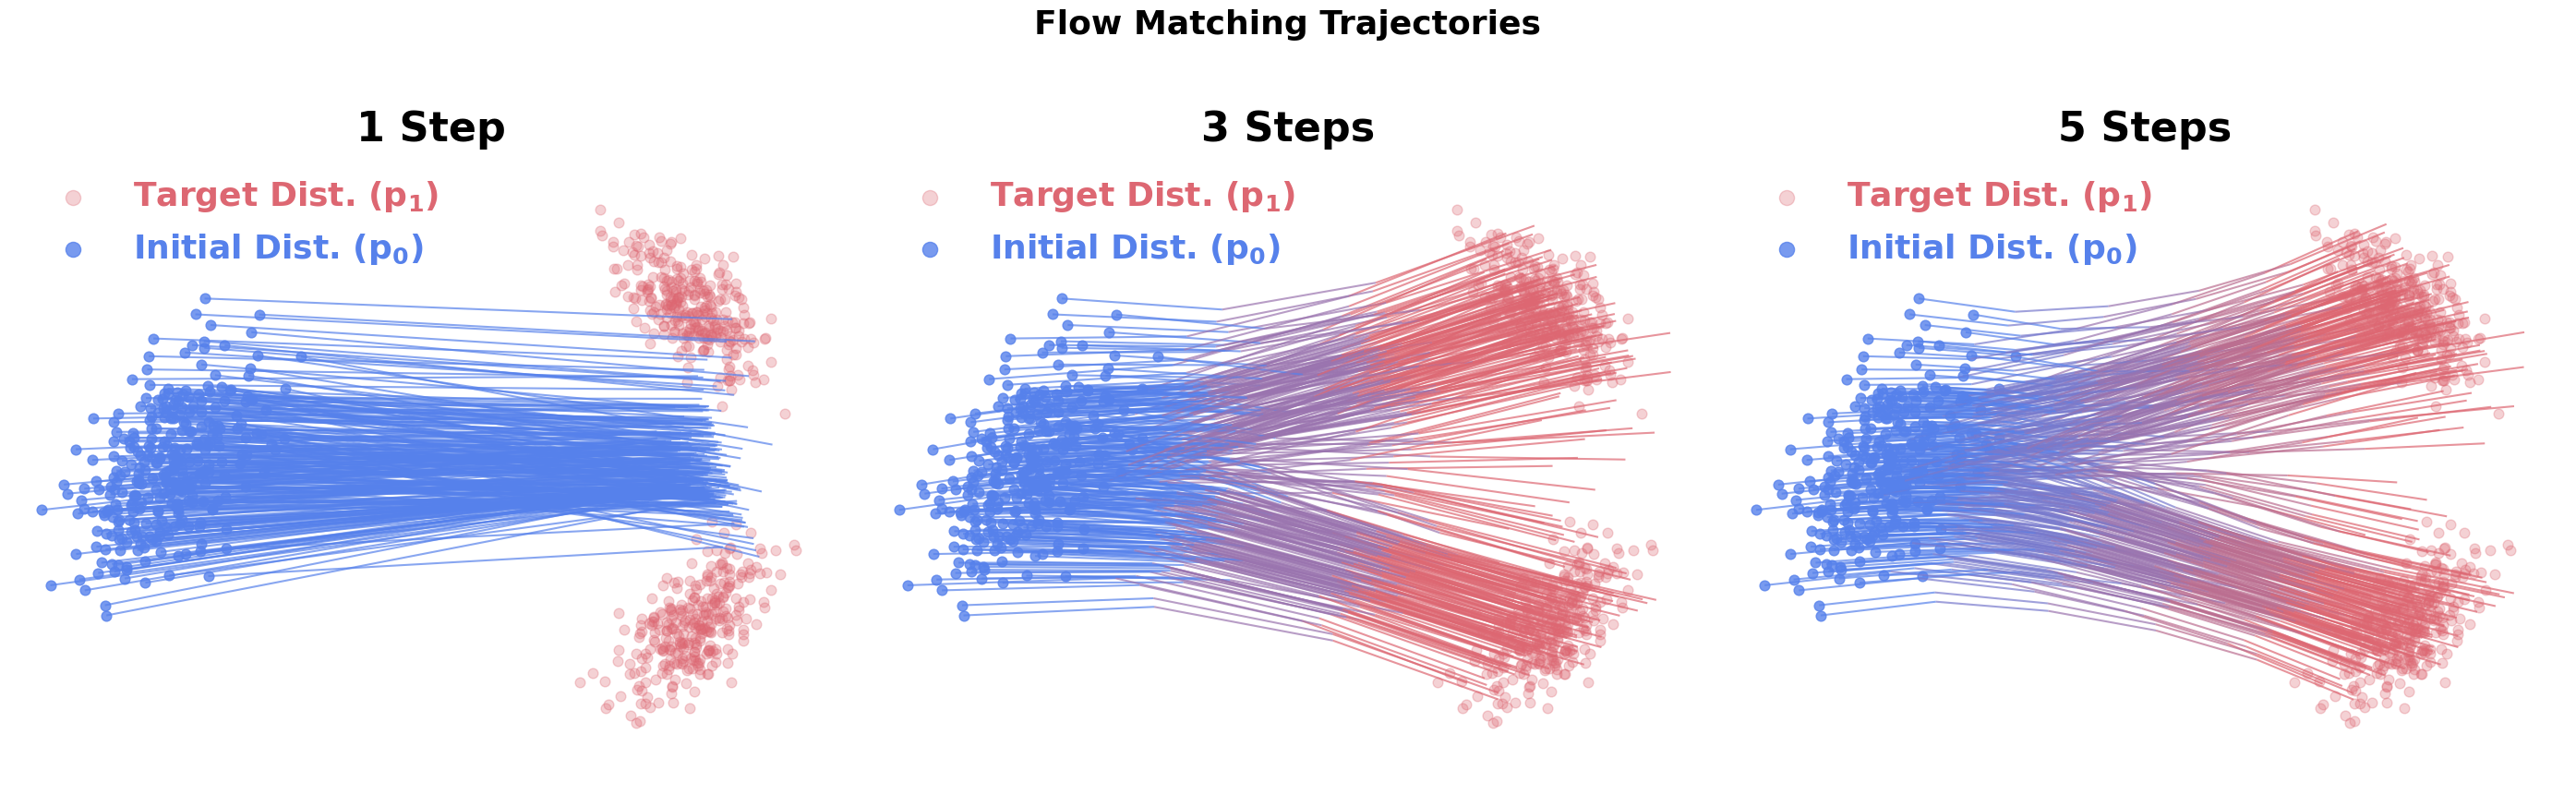

In [28]:
model = VectorFieldNet().to(device)
train_flow_matching(model, epochs=5000)
visualize_trajectories(model, n_samples=300)